# 线性回归的从零开始实现
我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器 

In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数w=[2,-3.4]T、b=4.2和噪声项c生成数据集及其标签：
y=Xw+b+c

In [ ]:
def sysnthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成均值为0，方差为1的随机数，大小是num_examples*w
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 增加噪音
    return X, y.reshape((-1, 1))  # 数组y重新调整形状为一个二维列向量

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = sysnthetic_data(true_w, true_b, 1000)

features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）

In [5]:
print('features:', features[0], '\nlabels:', labels[0])

features: tensor([-2.2058,  0.2508]) 
labels: tensor([-1.0832])


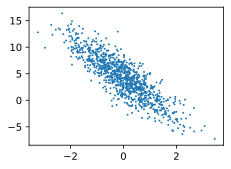

In [13]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1)

定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # 获取样本的index
    random.shuffle(indices) # 随机打乱样本顺序，目的是随机读取样本
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]  # 类似return

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.9078,  0.6720],
        [-0.6296,  0.8725],
        [-0.9896, -0.6221],
        [-0.8376,  0.2336],
        [-1.6266,  0.6916],
        [ 0.2108, -0.5243],
        [ 0.8930, -2.1419],
        [-0.7760,  0.0143],
        [-1.5102,  0.3557],
        [ 1.5724, -1.5605]]) 
 tensor([[ 8.9939e-02],
        [-1.2999e-02],
        [ 4.3414e+00],
        [ 1.7259e+00],
        [-1.4209e+00],
        [ 6.4107e+00],
        [ 1.3285e+01],
        [ 2.6173e+00],
        [-1.8116e-02],
        [ 1.2637e+01]])


定义初始化模型参数

In [8]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [9]:
def linreg(X, w, b):
    # 线性回归模型
    return torch.matmul(X, w) + b

定义损失函数

In [10]:
def squared_loss(y_hat, y):
    # 均方损失
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [14]:
def sgd(params, lr, batch_size):
    # 小批量随机梯度下降
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [15]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.029774
epoch 2, loss 0.000103
epoch 3, loss 0.000049


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [16]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-0.0004,  0.0004], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0005], grad_fn=<RsubBackward1>)
